In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

beneficiary = pd.read_csv('/content/Train_Beneficiarydata-1542865627584.csv')
inpatient = pd.read_csv('/content/Train_Inpatientdata-1542865627584.csv')
outpatient = pd.read_csv('/content/Train_Outpatientdata-1542865627584.csv')
labels = pd.read_csv('/content/Train-1542865627584.csv')

In [25]:
# 1. Basic shapes
print("beneficiary:", beneficiary.shape)
print("inpatient:", inpatient.shape)
print("outpatient:", outpatient.shape)
print("labels:", labels.shape)

# 2. Look at columns to confirm names
print("\nBeneficiary columns:\n", beneficiary.columns.tolist())
print("\nInpatient columns:\n", inpatient.columns.tolist())
print("\nOutpatient columns:\n", outpatient.columns.tolist())
print("\nLabels columns:\n", labels.columns.tolist())

# 3. Missing values % for a quick feeling of data quality
for name, df in [('beneficiary', beneficiary),
                 ('inpatient', inpatient),
                 ('outpatient', outpatient),
                 ('labels', labels)]:
    print(f"\n==== {name.upper()} ====")
    print((df.isna().mean() * 100).sort_values(ascending=False).head(10))

beneficiary: (138556, 25)
inpatient: (40474, 30)
outpatient: (517737, 27)
labels: (5410, 2)

Beneficiary columns:
 ['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

Inpatient columns:
 ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnos

PotentialFraud
No     4904
Yes     506
Name: count, dtype: int64

Fraud rate (%):
PotentialFraud
No     90.64695
Yes     9.35305
Name: proportion, dtype: float64


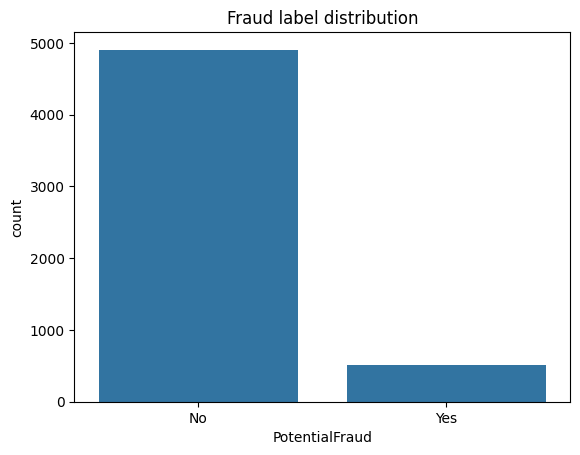

In [26]:
print(labels['PotentialFraud'].value_counts())
print("\nFraud rate (%):")
print(labels['PotentialFraud'].value_counts(normalize=True) * 100)

sns.countplot(data=labels, x='PotentialFraud')
plt.title('Fraud label distribution')
plt.show()

In [27]:
print("Unique BeneIDs:")
print("  beneficiary:", beneficiary['BeneID'].nunique())
print("  inpatient:", inpatient['BeneID'].nunique())
print("  outpatient:", outpatient['BeneID'].nunique())

print("\nUnique Providers:")
print("  inpatient:", inpatient['Provider'].nunique())
print("  outpatient:", outpatient['Provider'].nunique())
print("  labels:", labels['Provider'].nunique())


Unique BeneIDs:
  beneficiary: 138556
  inpatient: 31289
  outpatient: 133980

Unique Providers:
  inpatient: 2092
  outpatient: 5012
  labels: 5410


In [28]:
inpatient_agg = inpatient.groupby('Provider').agg(
    n_inpt_claims=('ClaimID', 'count'),
    n_inpt_bene=('BeneID', 'nunique'),
    inpt_total_reimb=('InscClaimAmtReimbursed', 'sum'),
    inpt_mean_reimb=('InscClaimAmtReimbursed', 'mean'),
    inpt_max_reimb=('InscClaimAmtReimbursed', 'max'),
    inpt_min_reimb=('InscClaimAmtReimbursed', 'min')
).reset_index()

inpatient_agg.head()


,Provider,n_inpt_claims,n_inpt_bene,inpt_total_reimb,inpt_mean_reimb,inpt_max_reimb,inpt_min_reimb
0,PRV51001,5,5,97000,19400.000000,42000,3000
1,PRV51003,62,53,573000,9241.935484,57000,0
2,PRV51007,3,3,19000,6333.333333,10000,3000
3,PRV51008,2,2,25000,12500.000000,21000,4000
4,PRV51011,1,1,5000,5000.000000,5000,5000


In [29]:
outpatient_agg = outpatient.groupby('Provider').agg(
    n_outpt_claims=('ClaimID', 'count'),
    n_outpt_bene=('BeneID', 'nunique'),
    outpt_total_reimb=('InscClaimAmtReimbursed', 'sum'),
    outpt_mean_reimb=('InscClaimAmtReimbursed', 'mean'),
    outpt_max_reimb=('InscClaimAmtReimbursed', 'max'),
    outpt_min_reimb=('InscClaimAmtReimbursed', 'min')
).reset_index()

outpatient_agg.head()


,Provider,n_outpt_claims,n_outpt_bene,outpt_total_reimb,outpt_mean_reimb,outpt_max_reimb,outpt_min_reimb
0,PRV51001,20,19,7640,382.000000,1500,10
1,PRV51003,70,66,32670,466.714286,3300,0
2,PRV51004,149,138,52170,350.134228,3300,0
3,PRV51005,1165,495,280910,241.124464,4080,0
4,PRV51007,69,56,14710,213.188406,3300,0


In [30]:
# merge: labels + inpatient + outpatient
provider_features = labels.merge(inpatient_agg, on='Provider', how='left') \
                          .merge(outpatient_agg, on='Provider', how='left')

# For providers that have only inpatient or only outpatient claims → NaNs → fill 0 for numeric cols
num_cols = provider_features.select_dtypes(include=[np.number]).columns
provider_features[num_cols] = provider_features[num_cols].fillna(0)

# Add combined features
provider_features['claims_total'] = provider_features['n_inpt_claims'] + provider_features['n_outpt_claims']
provider_features['bene_total'] = provider_features['n_inpt_bene'] + provider_features['n_outpt_bene']
provider_features['inpt_outpt_claim_ratio'] = provider_features['n_inpt_claims'] / (provider_features['n_outpt_claims'] + 1)

provider_features.head()

,Provider,PotentialFraud,n_inpt_claims,n_inpt_bene,inpt_total_reimb,inpt_mean_reimb,inpt_max_reimb,inpt_min_reimb,n_outpt_claims,n_outpt_bene,outpt_total_reimb,outpt_mean_reimb,outpt_max_reimb,outpt_min_reimb,claims_total,bene_total,inpt_outpt_claim_ratio
0,PRV51001,No,5.0,5.0,97000.0,19400.000000,42000.0,3000.0,20.0,19.0,7640.0,382.000000,1500.0,10.0,25.0,24.0,0.238095
1,PRV51003,Yes,62.0,53.0,573000.0,9241.935484,57000.0,0.0,70.0,66.0,32670.0,466.714286,3300.0,0.0,132.0,119.0,0.873239
2,PRV51004,No,0.0,0.0,0.0,0.000000,0.0,0.0,149.0,138.0,52170.0,350.134228,3300.0,0.0,149.0,138.0,0.000000
3,PRV51005,Yes,0.0,0.0,0.0,0.000000,0.0,0.0,1165.0,495.0,280910.0,241.124464,4080.0,0.0,1165.0,495.0,0.000000
4,PRV51007,No,3.0,3.0,19000.0,6333.333333,10000.0,3000.0,69.0,56.0,14710.0,213.188406,3300.0,0.0,72.0,59.0,0.042857


In [31]:
# Merge inpatient claims with beneficiary info
inpt_benef = inpatient.merge(beneficiary, on='BeneID', how='left')

# Find all chronic condition columns automatically
chronic_cols = [col for col in beneficiary.columns if col.startswith('ChronicCond_')]
print("Chronic condition columns:", chronic_cols)

# Base aggregation per Provider
benef_agg = inpt_benef.groupby('Provider').agg(
    avg_gender=('Gender', 'mean'),                 # average gender code
    avg_months_partA=('NoOfMonths_PartACov', 'mean'),
    avg_months_partB=('NoOfMonths_PartBCov', 'mean'),
    avg_IP_annual_reimb=('IPAnnualReimbursementAmt', 'mean'),
    avg_OP_annual_reimb=('OPAnnualReimbursementAmt', 'mean'),
    avg_IP_annual_deduct=('IPAnnualDeductibleAmt', 'mean'),
    avg_OP_annual_deduct=('OPAnnualDeductibleAmt', 'mean')
)

# Add chronic condition prevalence per provider (mean ≈ rate)
for col in chronic_cols:
    benef_agg[f'{col}_rate'] = inpt_benef.groupby('Provider')[col].mean()

benef_agg = benef_agg.reset_index()

benef_agg.head()

Chronic condition columns: ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']


,Provider,avg_gender,avg_months_partA,avg_months_partB,avg_IP_annual_reimb,avg_OP_annual_reimb,avg_IP_annual_deduct,avg_OP_annual_deduct,ChronicCond_Alzheimer_rate,ChronicCond_Heartfailure_rate,ChronicCond_KidneyDisease_rate,ChronicCond_Cancer_rate,ChronicCond_ObstrPulmonary_rate,ChronicCond_Depression_rate,ChronicCond_Diabetes_rate,ChronicCond_IschemicHeart_rate,ChronicCond_Osteoporasis_rate,ChronicCond_rheumatoidarthritis_rate,ChronicCond_stroke_rate
0,PRV51001,1.600000,12.000000,12.000000,77902.000000,1350.000000,2563.200000,236.00000,1.600000,1.200000,1.200000,1.800000,1.600000,1.200000,1.200000,1.200000,2.000000,1.400000,1.600000
1,PRV51003,1.661290,11.806452,11.806452,12696.612903,2217.741935,1604.064516,724.83871,1.483871,1.419355,1.370968,1.887097,1.629032,1.596774,1.209677,1.112903,1.790323,1.693548,1.887097
2,PRV51007,1.666667,12.000000,12.000000,11710.000000,2413.333333,2136.000000,470.00000,1.333333,1.000000,1.666667,2.000000,2.000000,1.333333,1.000000,1.000000,2.000000,1.666667,1.333333
3,PRV51008,1.500000,12.000000,12.000000,18750.000000,320.000000,1602.000000,165.00000,1.500000,2.000000,1.500000,1.500000,1.500000,2.000000,1.500000,1.000000,2.000000,2.000000,2.000000
4,PRV51011,2.000000,12.000000,12.000000,5000.000000,590.000000,1068.000000,90.00000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [32]:
provider_features = provider_features.merge(benef_agg, on='Provider', how='left')
provider_features = provider_features.fillna(0)

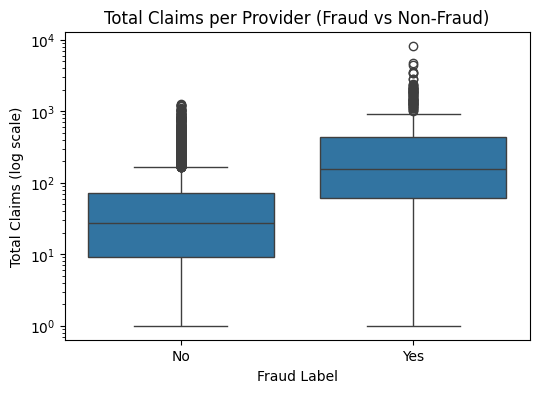

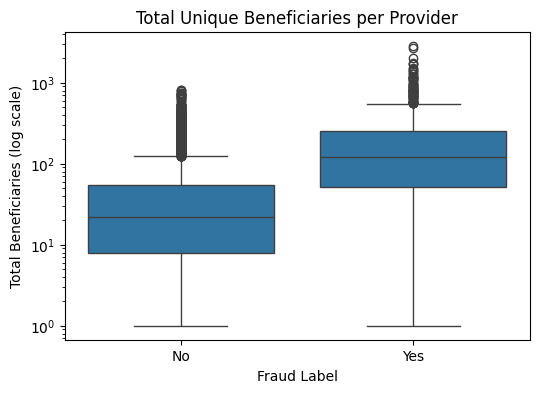

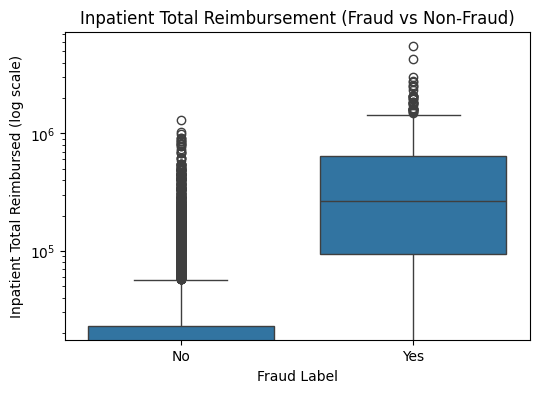

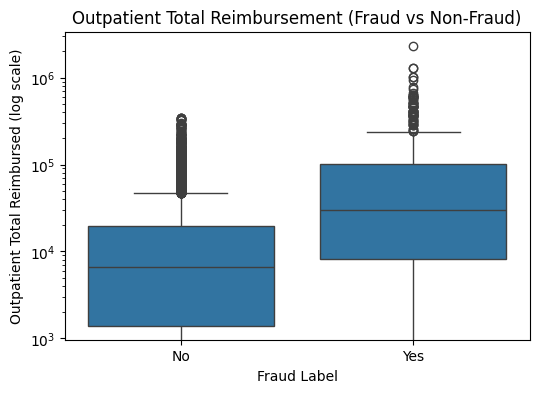

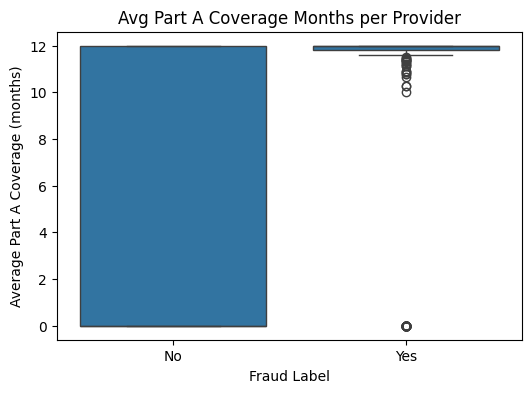

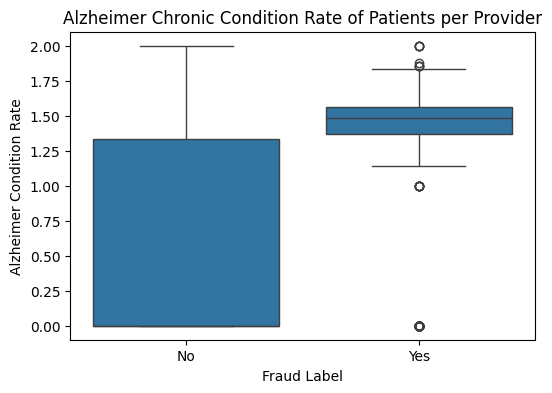

In [33]:
# 9️⃣ FRAUD vs NON-FRAUD EXPLORATIONS (UPDATED)

# Make sure provider_features exists and includes the new columns:
# claims_total, bene_total, inpt_total_reimb, outpt_total_reimb,
# avg_months_partA, avg_months_partB, avg_IP_annual_reimb, avg_OP_annual_reimb, etc.

# 9.1 – Total claims per provider (Fraud vs Non-Fraud)
plt.figure(figsize=(6, 4))
sns.boxplot(data=provider_features, x='PotentialFraud', y='claims_total')
plt.title("Total Claims per Provider (Fraud vs Non-Fraud)")
plt.yscale('log')   # log scale because counts can be very skewed
plt.xlabel("Fraud Label")
plt.ylabel("Total Claims (log scale)")
plt.show()

# 9.2 – Total unique beneficiaries per provider
plt.figure(figsize=(6, 4))
sns.boxplot(data=provider_features, x='PotentialFraud', y='bene_total')
plt.title("Total Unique Beneficiaries per Provider")
plt.yscale('log')
plt.xlabel("Fraud Label")
plt.ylabel("Total Beneficiaries (log scale)")
plt.show()

# 9.3 – Inpatient total reimbursement per provider
plt.figure(figsize=(6, 4))
sns.boxplot(data=provider_features, x='PotentialFraud', y='inpt_total_reimb')
plt.title("Inpatient Total Reimbursement (Fraud vs Non-Fraud)")
plt.yscale('log')
plt.xlabel("Fraud Label")
plt.ylabel("Inpatient Total Reimbursed (log scale)")
plt.show()

# 9.4 – Outpatient total reimbursement per provider
plt.figure(figsize=(6, 4))
sns.boxplot(data=provider_features, x='PotentialFraud', y='outpt_total_reimb')
plt.title("Outpatient Total Reimbursement (Fraud vs Non-Fraud)")
plt.yscale('log')
plt.xlabel("Fraud Label")
plt.ylabel("Outpatient Total Reimbursed (log scale)")
plt.show()

# 9.5 – Average Part A coverage months (beneficiary feature) vs fraud
plt.figure(figsize=(6, 4))
sns.boxplot(data=provider_features, x='PotentialFraud', y='avg_months_partA')
plt.title("Avg Part A Coverage Months per Provider")
plt.xlabel("Fraud Label")
plt.ylabel("Average Part A Coverage (months)")
plt.show()

# 9.6 – Example chronic condition rate vs fraud (Alzheimer)
if 'ChronicCond_Alzheimer_rate' in provider_features.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=provider_features, x='PotentialFraud', y='ChronicCond_Alzheimer_rate')
    plt.title("Alzheimer Chronic Condition Rate of Patients per Provider")
    plt.xlabel("Fraud Label")
    plt.ylabel("Alzheimer Condition Rate")
    plt.show()
else:
    print("Column 'ChronicCond_Alzheimer_rate' not found – check benef_agg creation.")

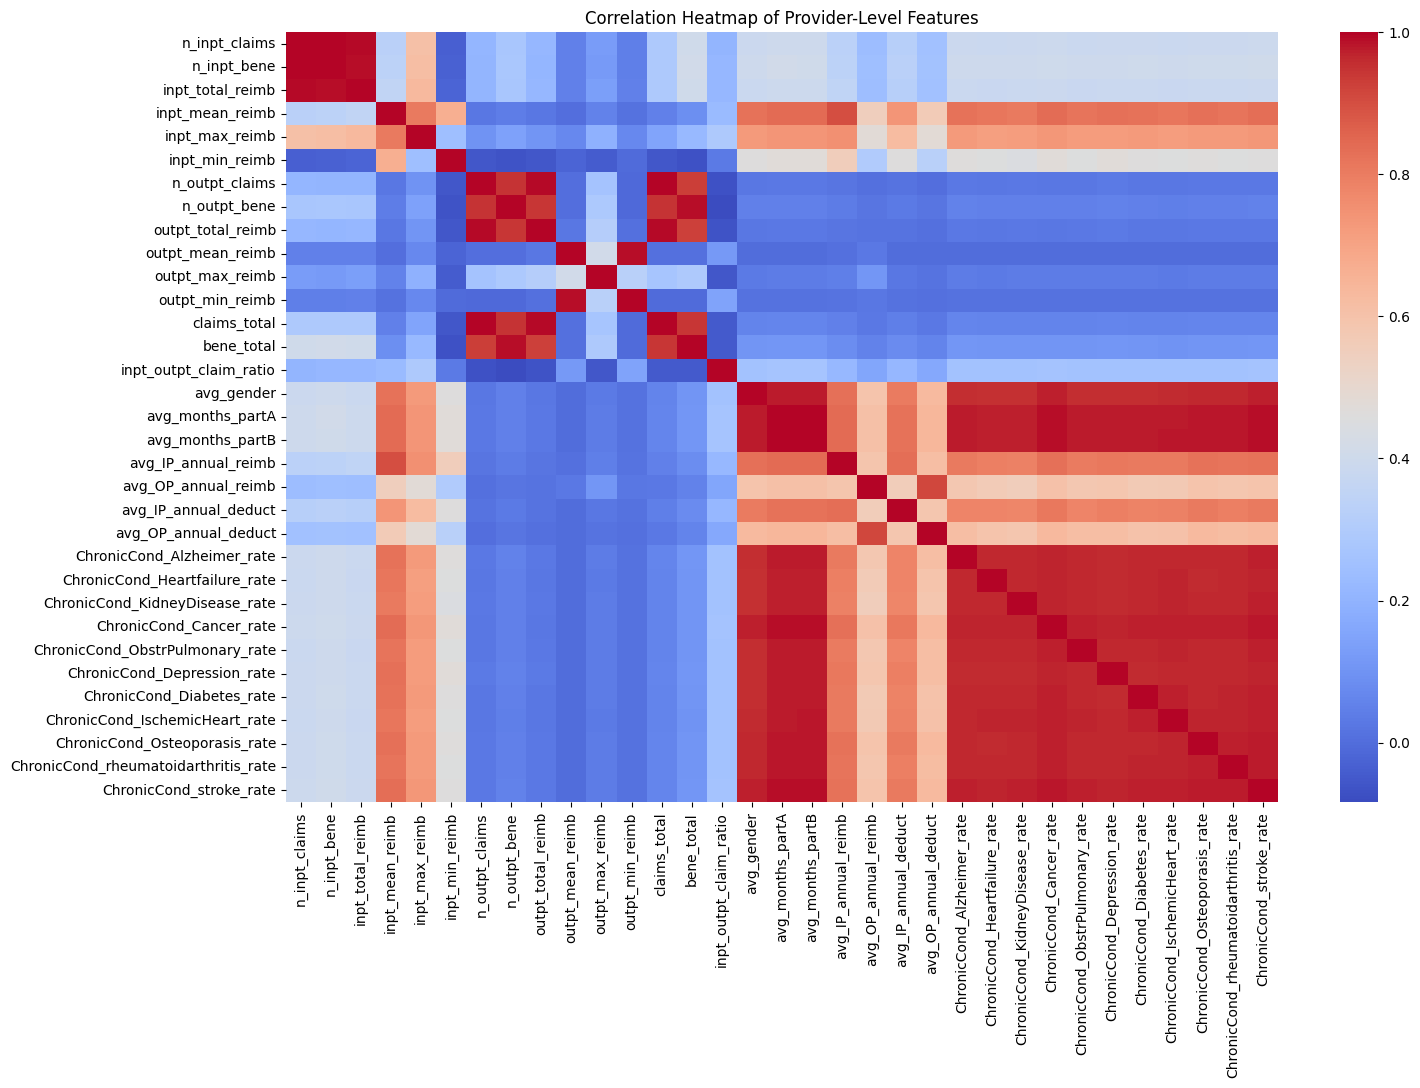

In [34]:
plt.figure(figsize=(16, 10))
sns.heatmap(provider_features.select_dtypes(include=[np.number]).corr(), cmap='coolwarm')
plt.title("Correlation Heatmap of Provider-Level Features")
plt.show()

In [35]:
provider_features.to_csv('/content/provider_featuress.csv', index=False)
print("Notebook 1 COMPLETE — provider_features.csv saved successfully!")

Notebook 1 COMPLETE — provider_features.csv saved successfully!


### Notebook 1 Summary — Data Exploration & Feature Engineering

- Loaded all training datasets: Beneficiary, Inpatient, Outpatient, and Labels.  
- Performed basic exploration: shapes, columns, datatypes, and missing values.  
- Verified table connections using BeneID and Provider.  
- Analyzed the fraud label distribution and confirmed strong class imbalance.  
- Conducted EDA comparing fraudulent vs non-fraudulent providers.  
- Aggregated inpatient claims per provider (claim counts, beneficiary counts, reimbursement statistics).  
- Aggregated outpatient claims per provider with similar metrics.  
- Created beneficiary-based features (coverage months, annual reimbursements/deductibles, chronic condition rates).  
- Engineered combined features such as total claims, total beneficiaries, and inpatient/outpatient ratios.  
- Merged all engineered features into a single provider-level dataset (`provider_featuress.csv`) for use in Notebook 2.  